In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown,display
import datetime
import time
import re
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score




asset_directory = "data/data_asset_choosed/487_None_old4"
file_name = "data/data_asset_choosed/487_None/487_51.csv"
df_asset = pd.read_csv(file_name,parse_dates=[1])
df_asset.head(10)
#print(len(df_asset[~np.isnan(df_asset['fuel'])]))

/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,asset,recorded_at,MDI_OBD_SPEED,GPS_SPEED,MDI_OBD_RPM,MDI_OBD_ENGINE_LOAD,MDI_OBD_FUEL,ODO_FULL_METER,MDI_DASHBOARD_MILEAGE,distance_meter,...,avrg_speed,acceleration,distance_speed,distance_cum,delay,fuel,filled_speed,filled_meter,filled_load,filled_rpm
0,487,2017-10-15 18:49:03,NaN,55992.0,NaN,NaN,3618573.0,5063840.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,487,2017-10-15 18:49:05,105.0,55529.0,2458.0,NaN,3618587.0,NaN,NaN,NaN,...,NaN,NaN,58.333333,58.333333,2.0,NaN,False,False,False,False
2,487,2017-10-15 18:49:06,NaN,55282.0,NaN,NaN,NaN,NaN,NaN,NaN,...,105.000000,NaN,29.166667,87.500000,1.0,NaN,True,False,True,True
3,487,2017-10-15 18:49:08,104.0,55286.0,NaN,NaN,3618601.0,5063952.0,NaN,NaN,...,105.000000,1.0,57.777778,145.277778,2.0,14.0,False,False,True,True
4,487,2017-10-15 18:49:10,105.0,55429.0,2437.0,NaN,3618615.0,NaN,NaN,NaN,...,104.500000,-1.0,58.333333,203.611111,2.0,14.0,False,True,True,False
5,487,2017-10-15 18:49:11,NaN,55337.0,NaN,NaN,NaN,5064064.0,NaN,112.0,...,104.666667,NaN,29.166667,232.777778,1.0,14.0,True,False,True,True
6,487,2017-10-15 18:49:13,106.0,55534.0,NaN,NaN,3618629.0,NaN,NaN,112.0,...,104.666667,-1.0,58.888889,291.666667,2.0,14.0,False,True,True,True
7,487,2017-10-15 18:49:15,NaN,55417.0,2453.0,NaN,3618636.0,NaN,NaN,NaN,...,105.000000,NaN,58.888889,350.555556,2.0,7.0,True,False,True,False
8,487,2017-10-15 18:49:17,105.0,55550.0,NaN,NaN,3618647.0,5064176.0,NaN,112.0,...,105.000000,1.0,58.333333,408.888889,2.0,11.0,False,False,True,True
9,487,2017-10-15 18:49:18,NaN,55660.0,NaN,NaN,NaN,NaN,NaN,112.0,...,105.000000,NaN,29.166667,438.055556,1.0,11.0,True,True,True,True


In [3]:
df_corr = df_asset.drop(['asset','MDI_DASHBOARD_MILEAGE'],axis=1)
df_corr.corr('pearson')['MDI_OBD_FUEL']

MDI_OBD_SPEED         -0.333423
GPS_SPEED             -0.331632
MDI_OBD_RPM           -0.301493
MDI_OBD_ENGINE_LOAD   -0.318598
MDI_OBD_FUEL           1.000000
ODO_FULL_METER         0.999670
distance_meter        -0.037423
speed_filled          -0.287032
meter_filled           0.999669
load_filled           -0.065688
rpm_filled            -0.087944
avrg_speed            -0.761141
acceleration           0.011854
distance_speed        -0.015603
distance_cum           0.999675
delay                  0.091362
fuel                  -0.056092
filled_speed          -0.013801
filled_meter           0.014531
filled_load           -0.009557
filled_rpm            -0.021423
Name: MDI_OBD_FUEL, dtype: float64

/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


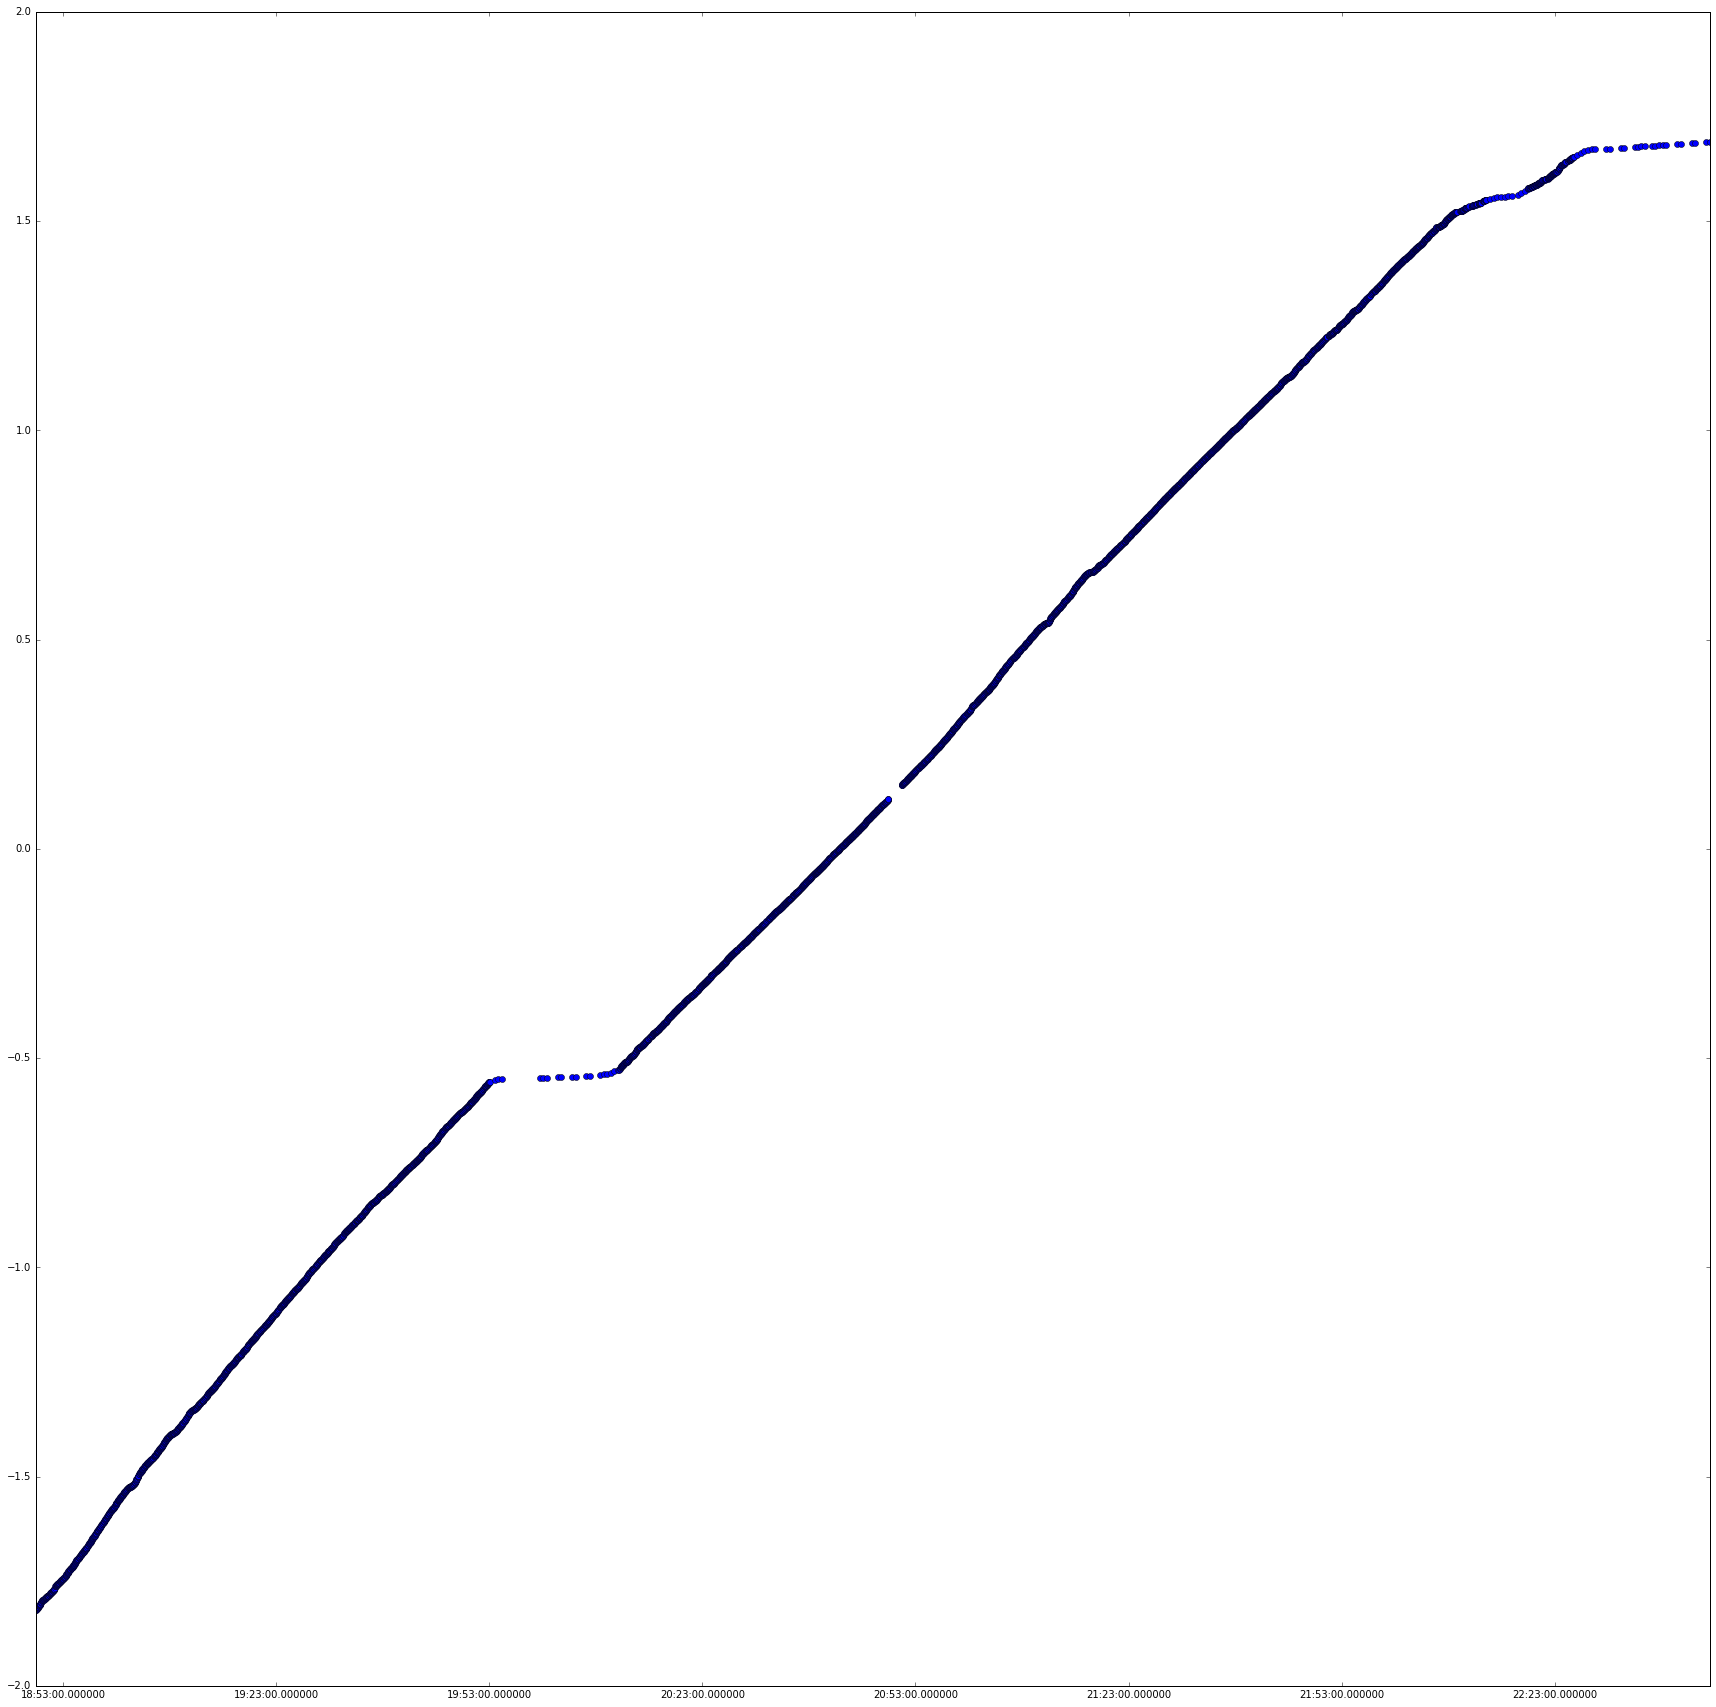

In [6]:
#Statsmodel
#With min max scaling
def min_max_format(df):
    min_max_scaler = preprocessing.StandardScaler()
    df= df[~np.isnan(df['MDI_OBD_FUEL']) & ~np.isnan(df['meter_filled']) & ~np.isnan(df['speed_filled']) ]
    #df = df[np.isfinite(df['meter_filled'])]
    #df = df[np.isfinite(df['speed_filled'])]
    time = df['recorded_at']
    X = pd.DataFrame(min_max_scaler.fit_transform(df[['speed_filled','meter_filled','distance_cum']]),index=df.index)

    y = pd.DataFrame(min_max_scaler.fit_transform(df['MDI_OBD_FUEL'].reshape(-1,1)),index=df.index)
    return [y,X,time]

y = min_max_format(df_asset)[0]
X = min_max_format(df_asset)[1]
time = min_max_format(df_asset)[2]
X = sm.add_constant(X)
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(time,y, 'o',label="data")
plt.savefig("regression_MDI_OBD_FUEL.pdf")

In [7]:
# Fit model and print summary
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT(),missing='drop')
ols_model = sm.OLS(y,X)

ols_results = ols_model.fit()
rlm_results = rlm_model.fit()

print(rlm_results.summary())
print(ols_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      0   No. Observations:                 4839
Model:                            RLM   Df Residuals:                     4835
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 09 Mar 2018                                         
Time:                        20:48:52                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.000     12.177      0.0

/homes/wsahel/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


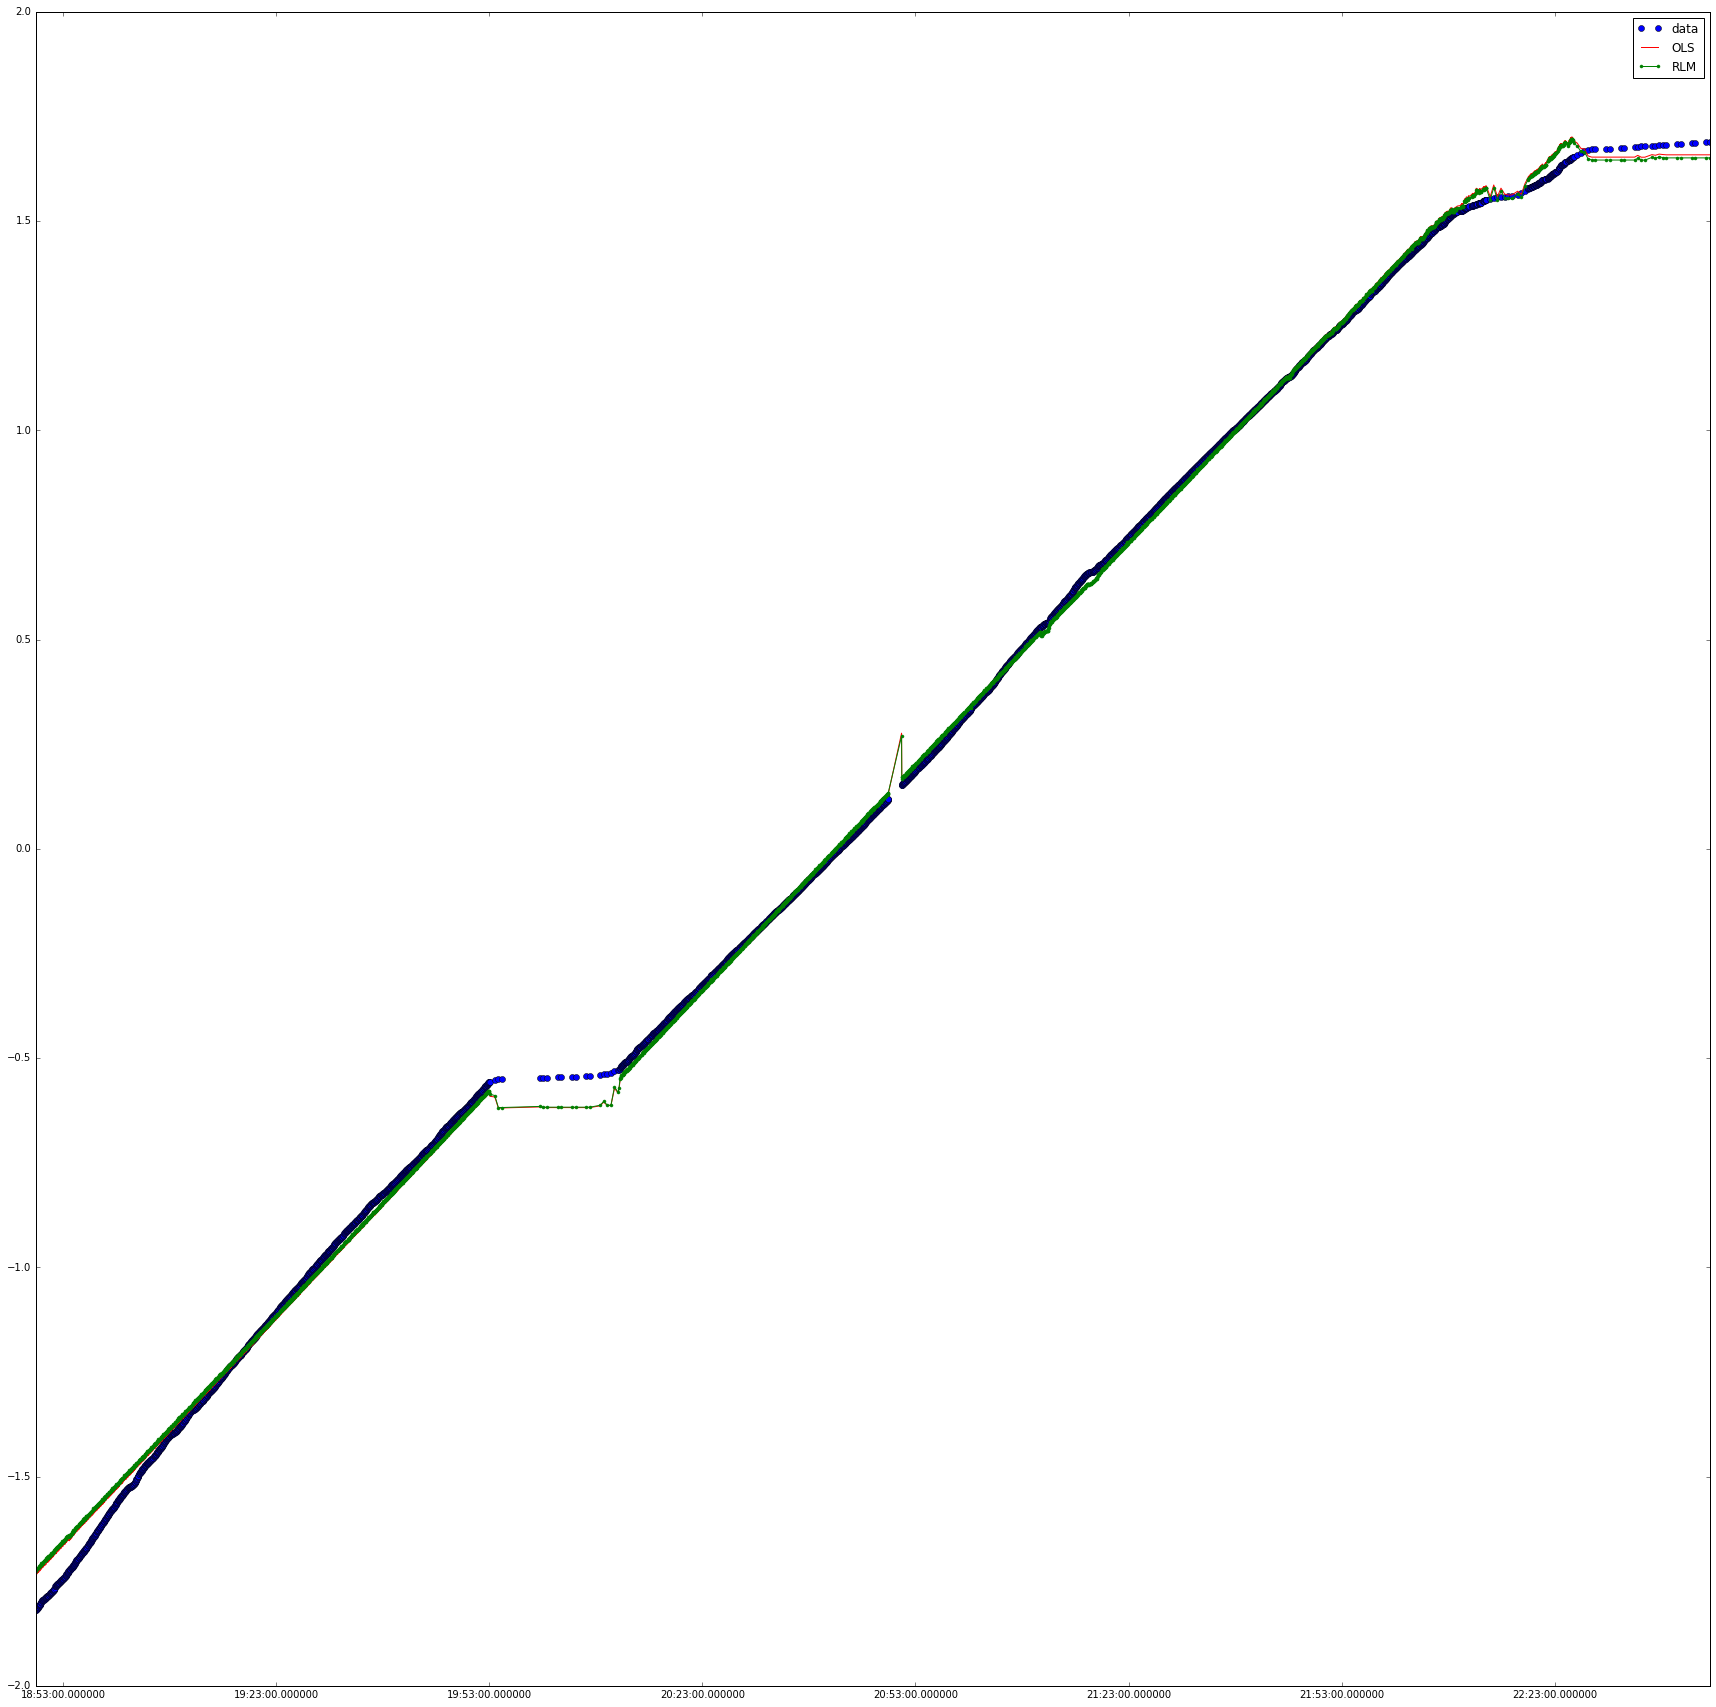

In [8]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
ax.plot(time,y, 'o',label="data")
prstd, iv_l, iv_u = wls_prediction_std(ols_results)
ax.plot(time, ols_results.fittedvalues, 'r-', label="OLS")
ax.plot(time, rlm_results.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")





In [30]:
len(rlm_results.fittedvalues[rlm_results.fittedvalues<0])

2423

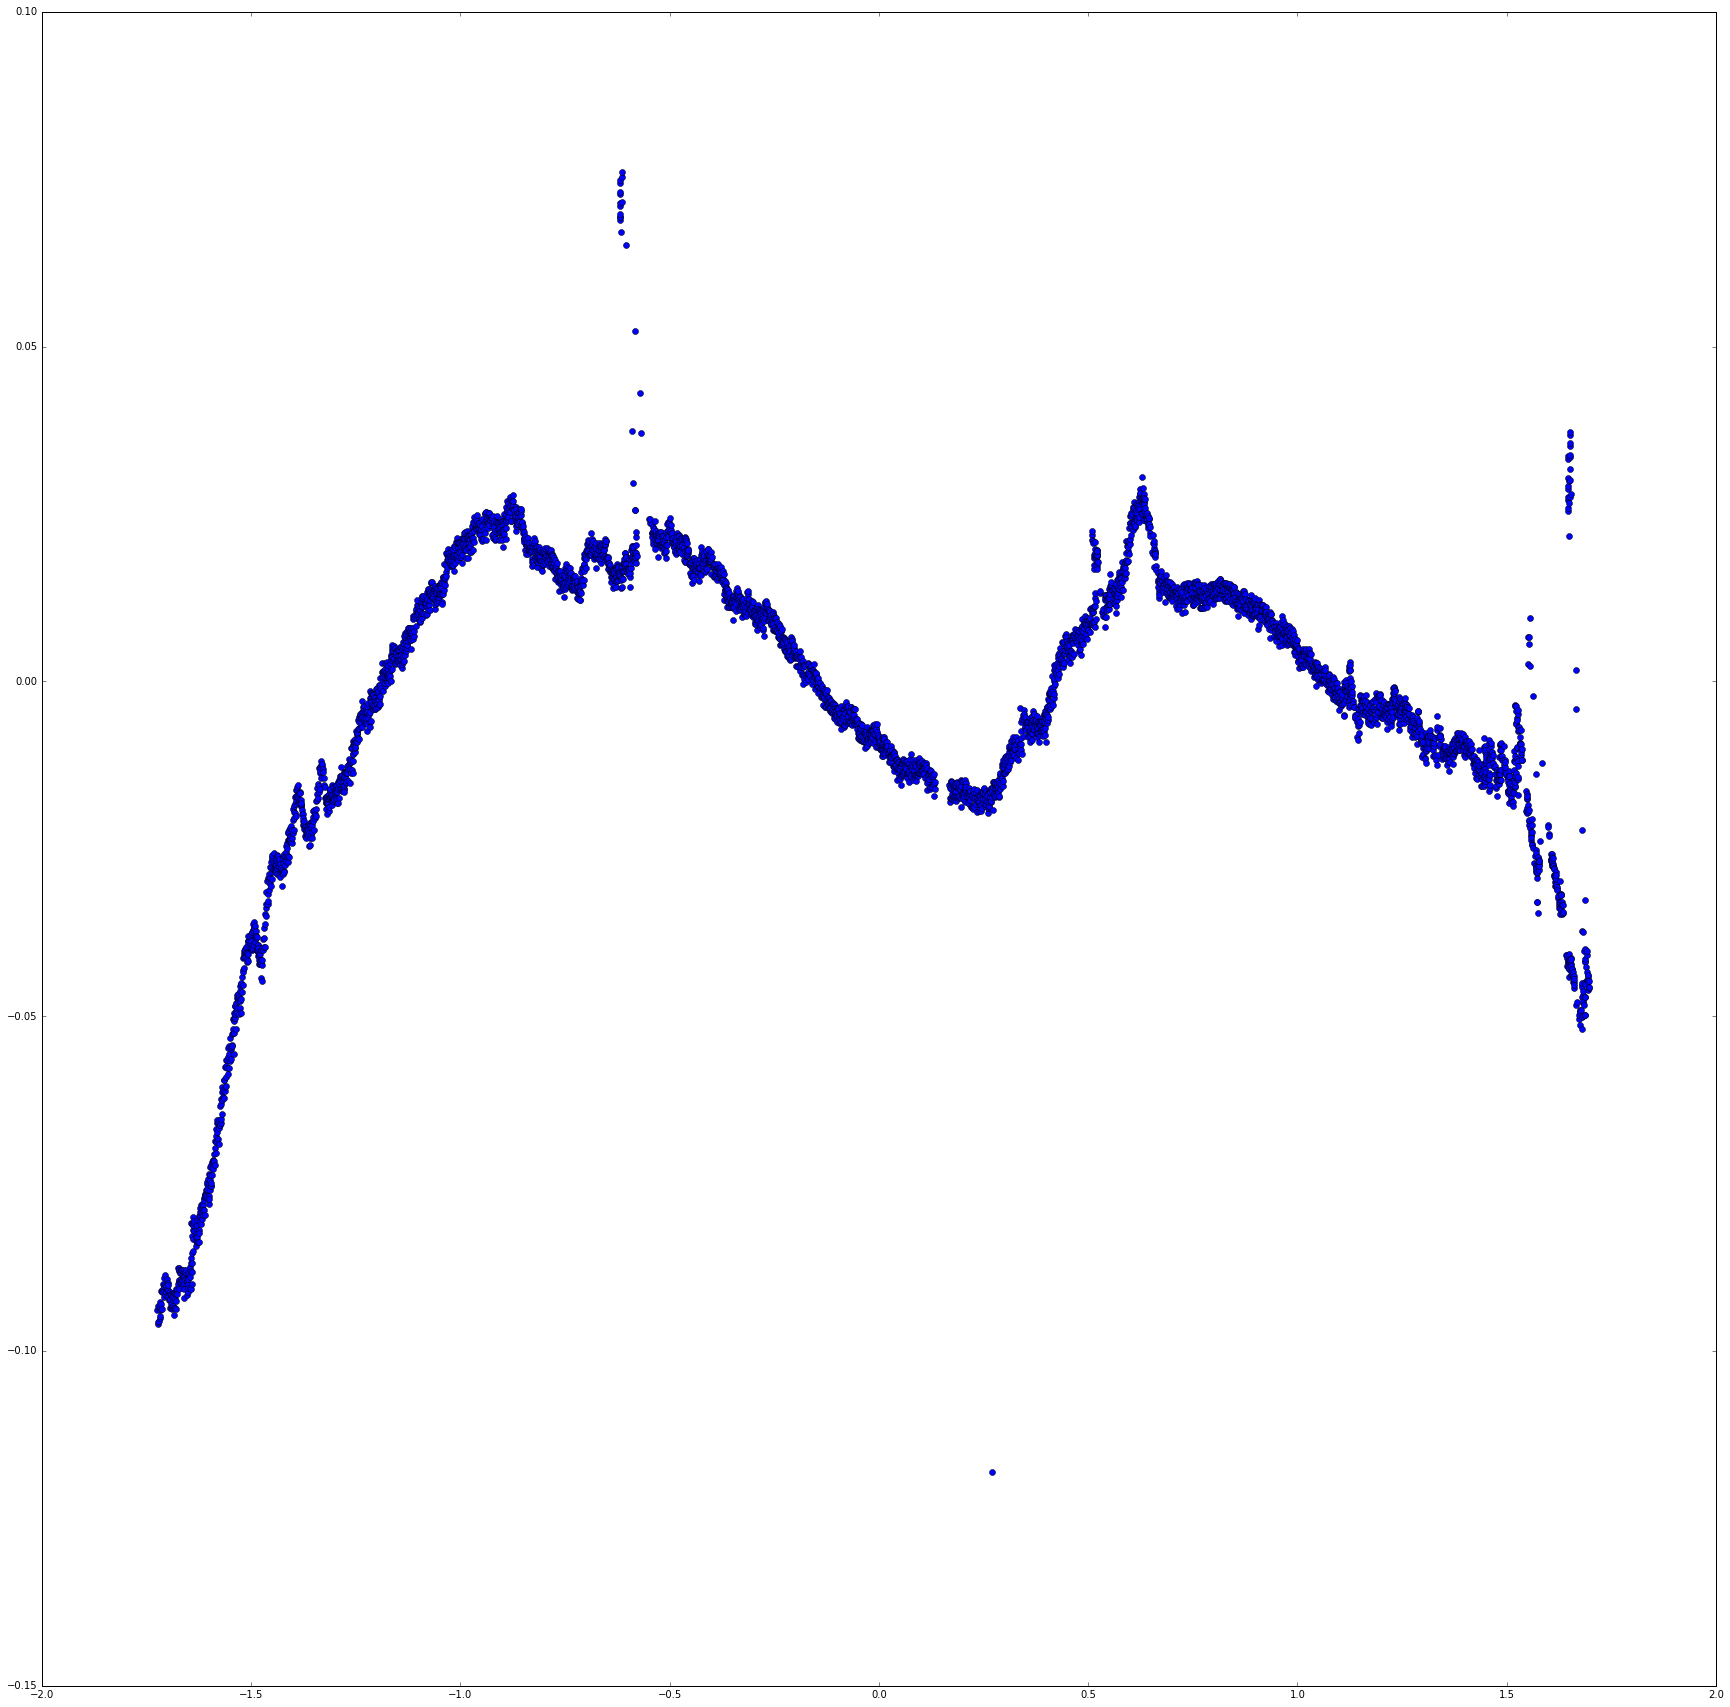

In [9]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(rlm_results.fittedvalues,rlm_results.resid, 'o',label="residuals vs fitted")
plt.savefig('residuals_MDI_OBD_FUEL.pdf')

/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


ValueError: shapes (4604,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

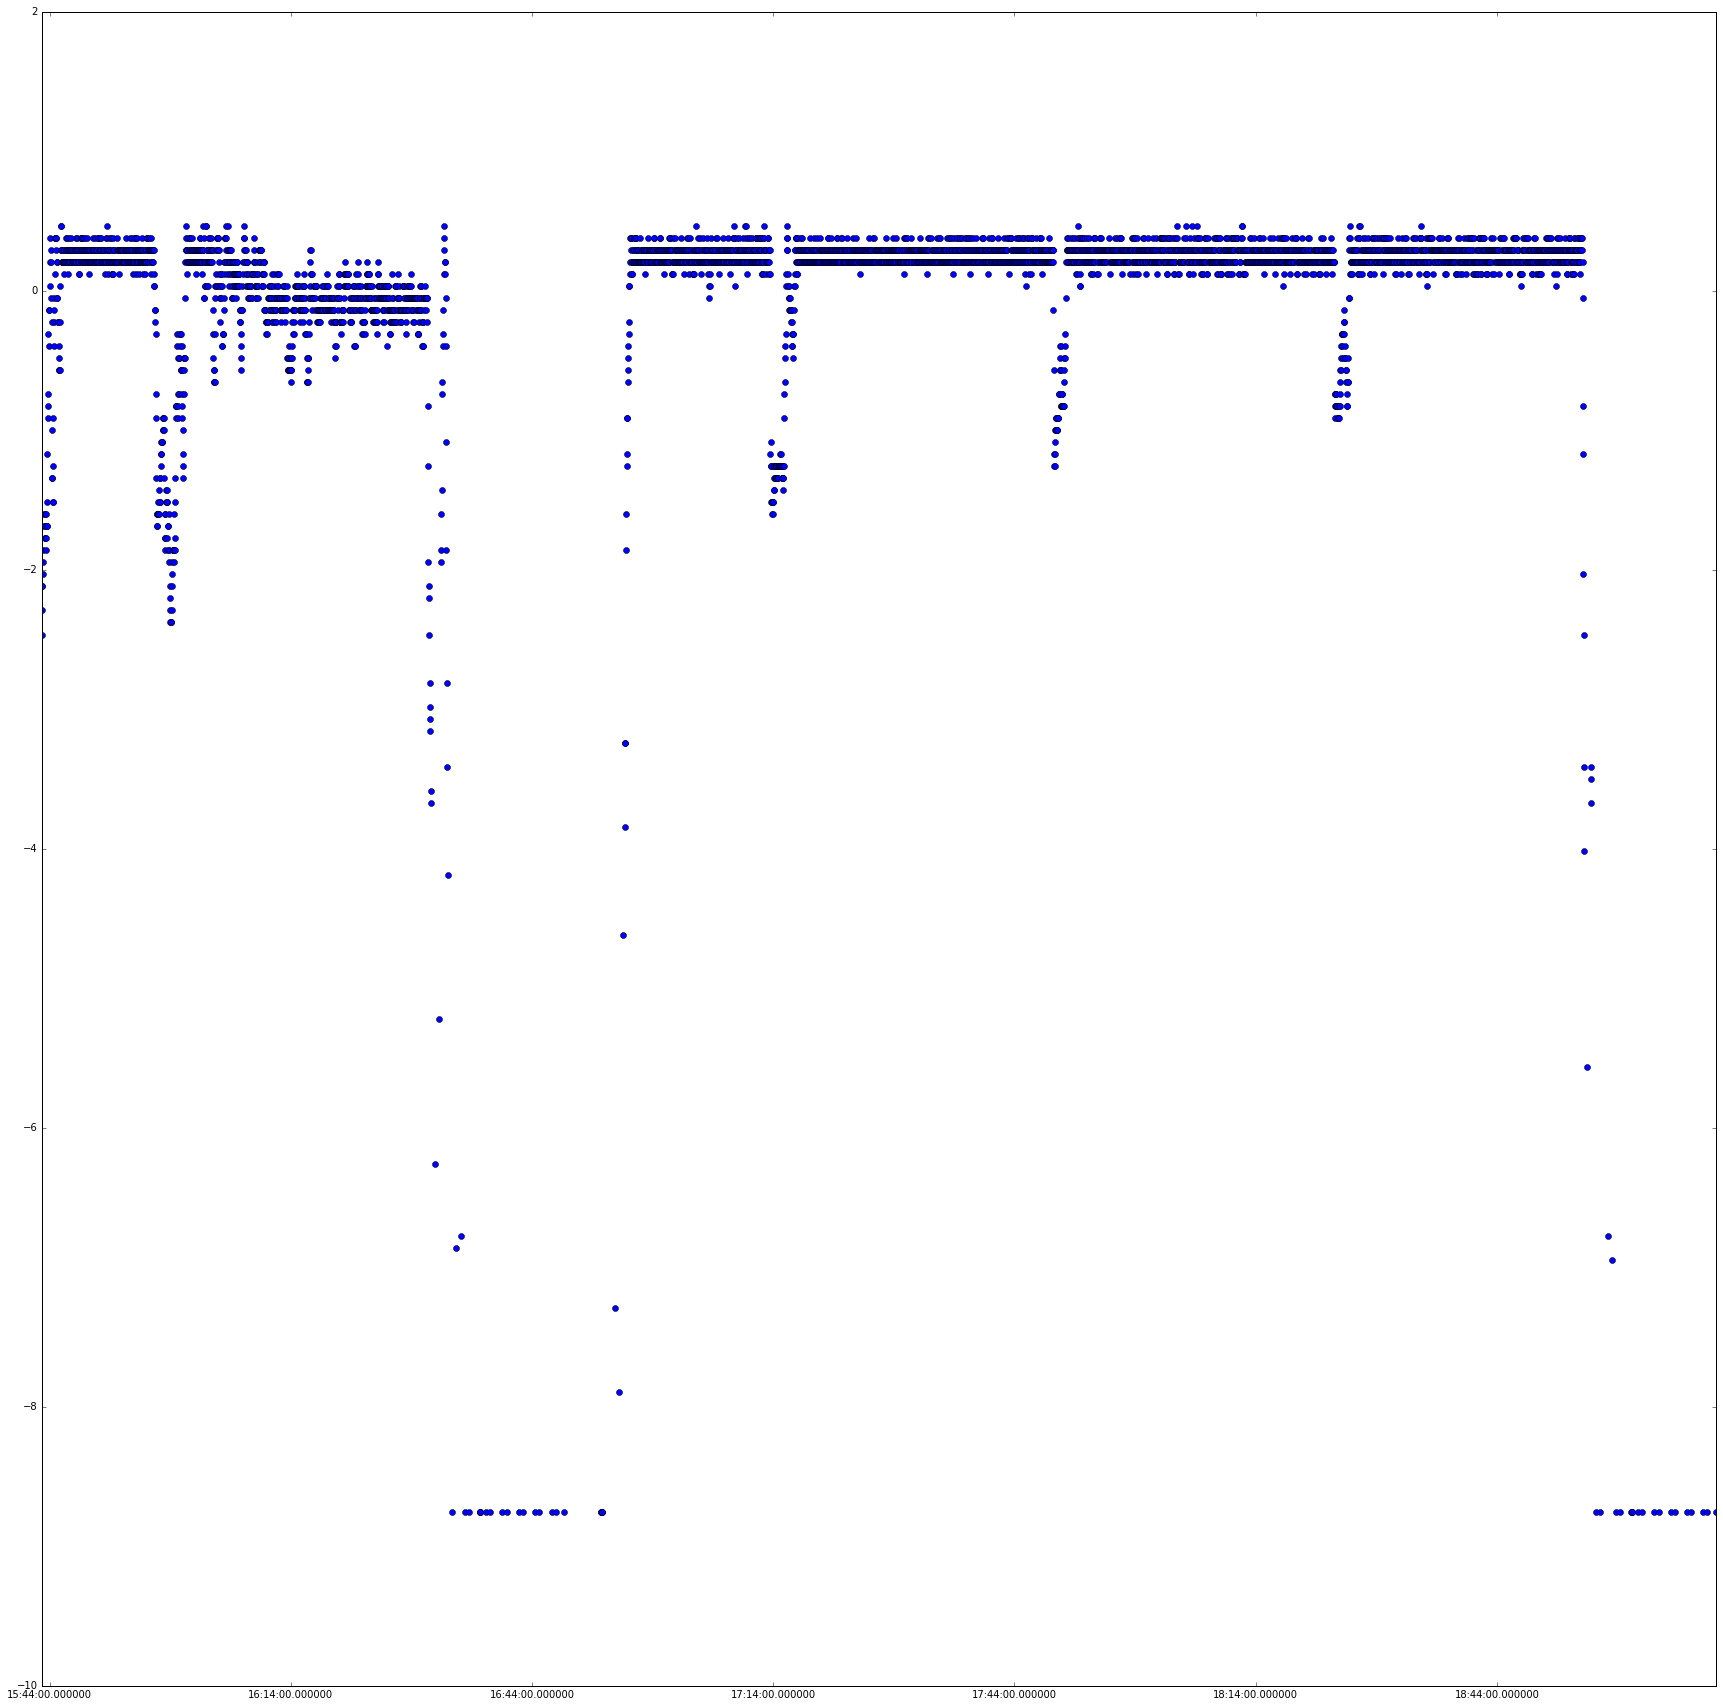

In [19]:
#Test set:
file_test = "data/data_asset_choosed/487_None/487_42.csv"
df_test = pd.read_csv(file_test,parse_dates=[1])
X_test = min_max_format(df_test)[1]
y_test = min_max_format(df_test)[0]
time_test = min_max_format(df_test)[2]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
ax.plot(time_test,y_test, 'o',label="data")
ax.plot(time_test, ols_results.predict(X_test), 'r-', label="OLS")
ax.plot(time_test, rlm_results.predict(X_test), 'g.-', label="RLM")
ax.legend(loc="best")

In [60]:
#With log transformation
def log1_format(df):
    df= df[~np.isnan(df['MDI_OBD_FUEL'])]
    df = df[np.isfinite(df['meter_filled'])]
    time = df['recorded_at']
    X = pd.DataFrame(np.log1p(df[['speed_filled','meter_filled','distance_cum','avrg_speed']]),index=df.index)

    y = pd.DataFrame(np.log1p(df['MDI_OBD_FUEL'].reshape(-1,1)),index=df.index)
    return[y,X,time]

y = log1_format(df_asset)[0]
X = log1_format(df_asset)[1]
time = log1_format(df_asset)[2]
# Fit model and print summary
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT(),missing='drop')
ols_model = sm.OLS(y,X)

ols_results = ols_model.fit()
rlm_results = rlm_model.fit()

print(rlm_results.summary())
print(ols_results.summary())



                    Robust linear Model Regression Results                    
Dep. Variable:                      0   No. Observations:                 6935
Model:                            RLM   Df Residuals:                     6931
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Mar 2018                                         
Time:                        18:39:01                                         
No. Iterations:                    50                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
speed_filled    -0.0031   4.94e-05    -62.387   

/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


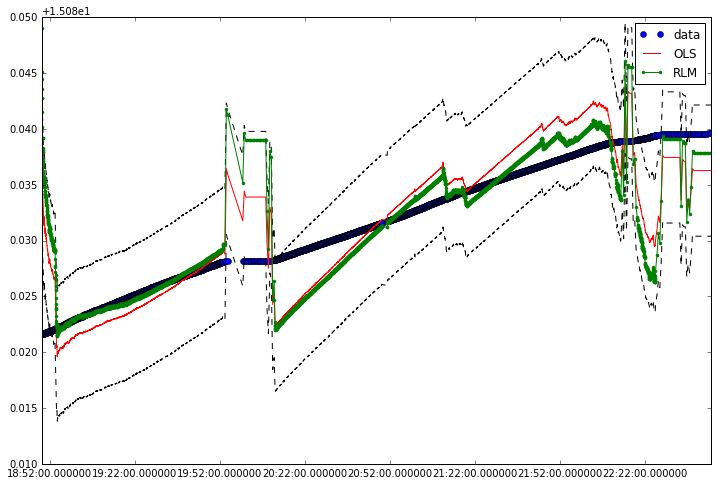

In [61]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(time,y, 'o',label="data")
prstd, iv_l, iv_u = wls_prediction_std(ols_results)
ax.plot(time, ols_results.fittedvalues, 'r-', label="OLS")
ax.plot(time, iv_u, 'k--')
ax.plot(time, iv_l, 'k--')
ax.plot(time, rlm_results.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")




/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


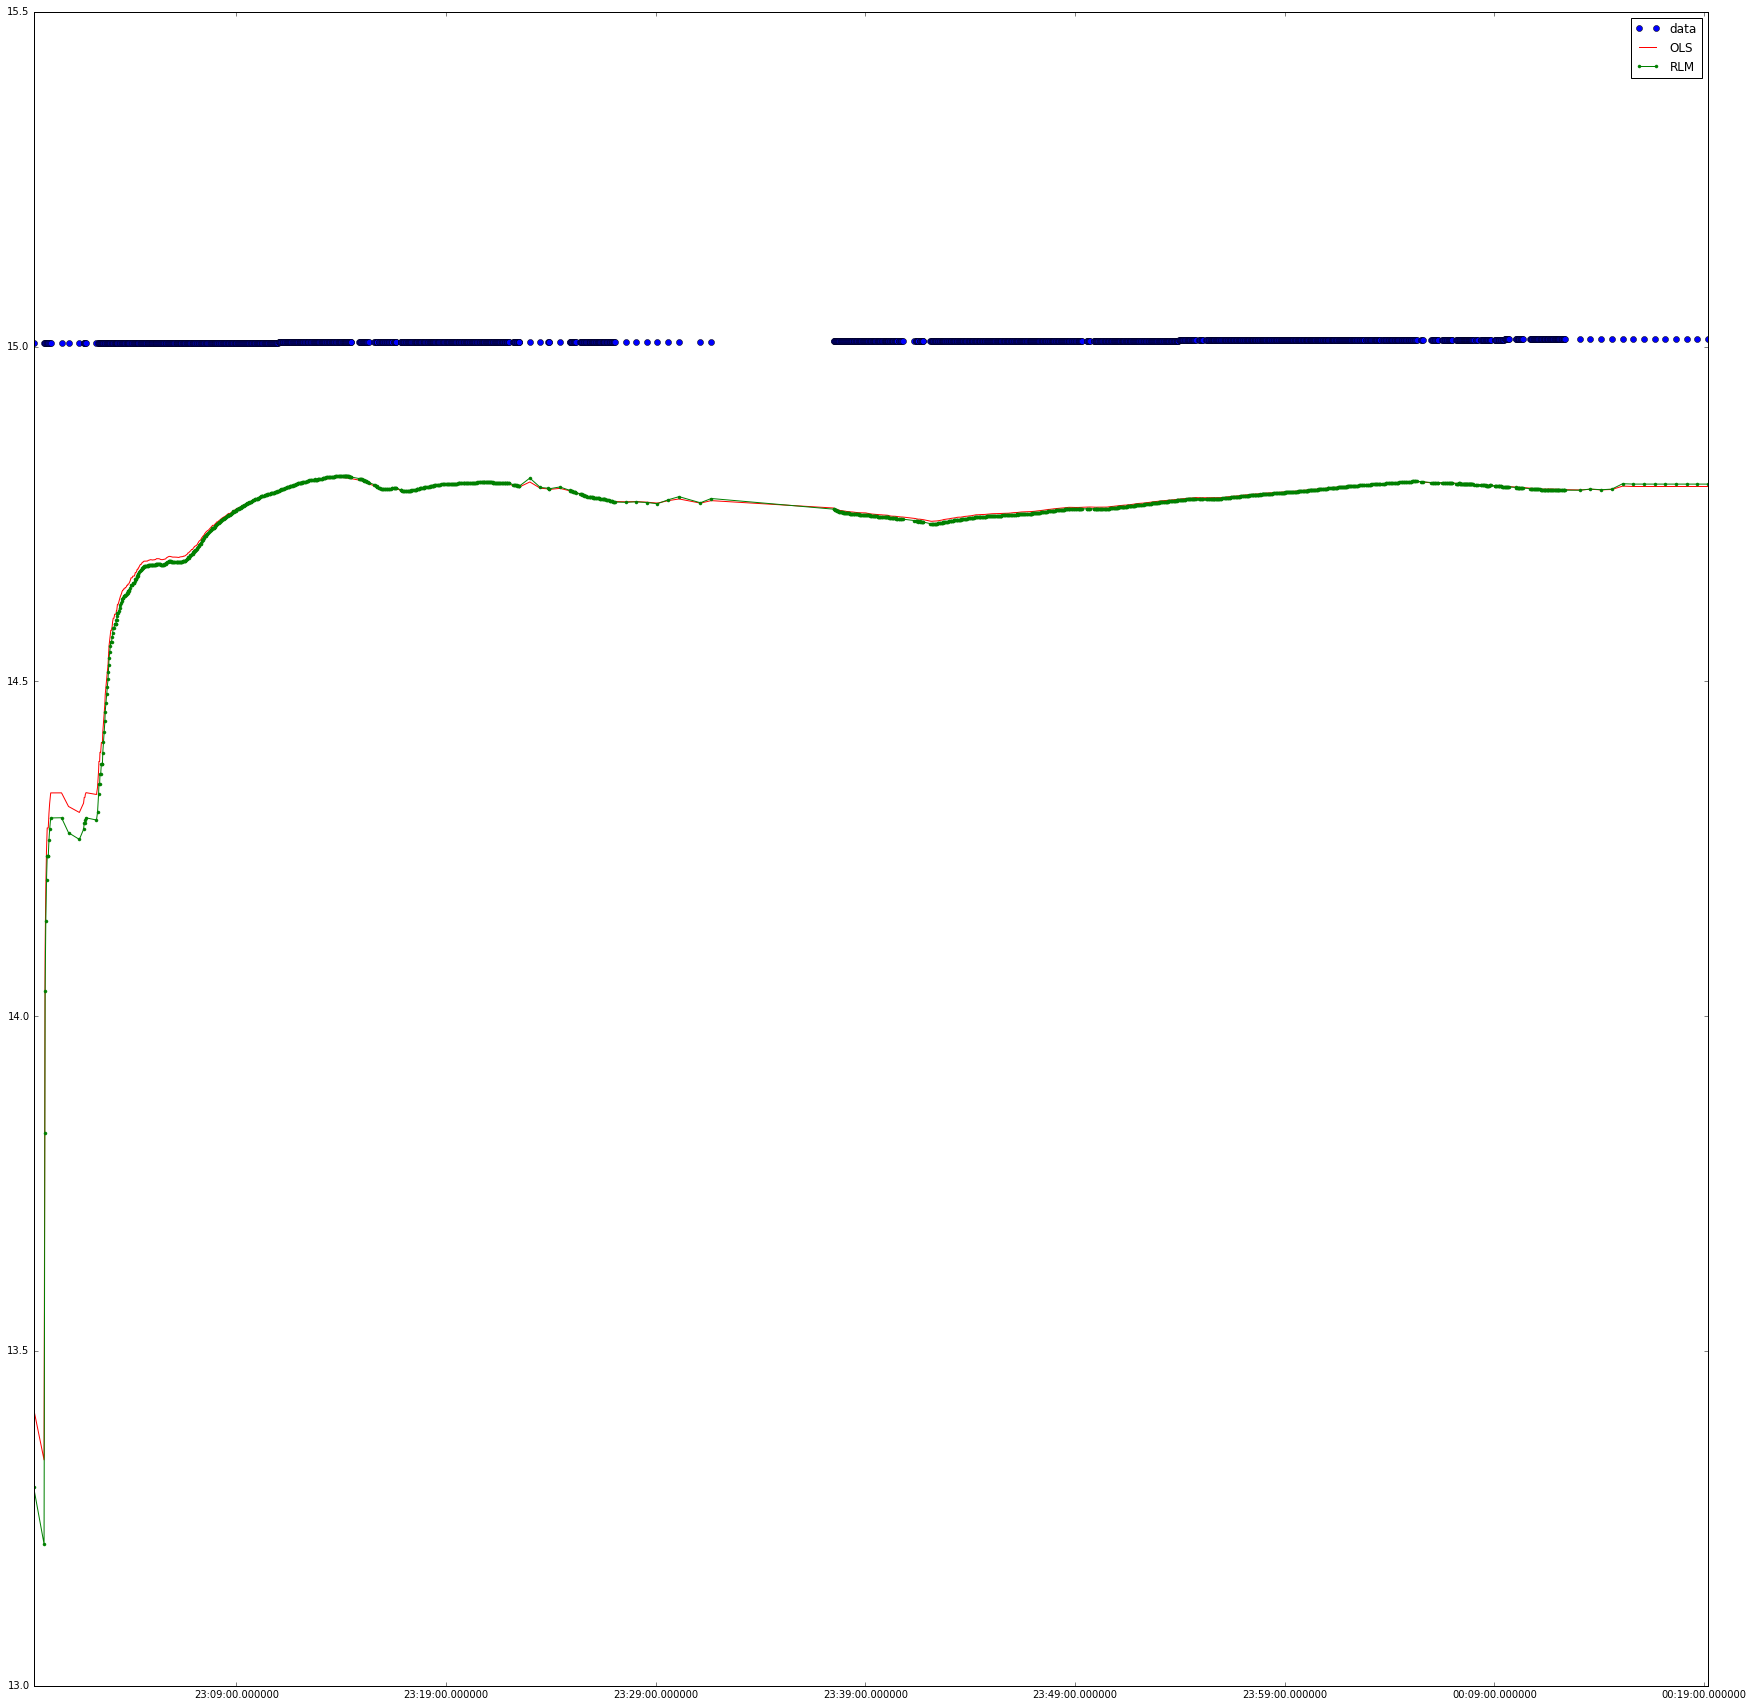

In [63]:
#Test set:
file_test = "data/data_asset_choosed/487_None/487_21.csv"
df_test = pd.read_csv(file_test,parse_dates=[1])
X_test = log1_format(df_test)[1]
y_test = log1_format(df_test)[0]
time_test = log1_format(df_test)[2]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
ax.plot(time_test,y_test, 'o',label="data")
ax.plot(time_test, ols_results.predict(X_test), 'r-', label="OLS")
ax.plot(time_test, rlm_results.predict(X_test), 'g.-', label="RLM")
ax.legend(loc="best")

/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


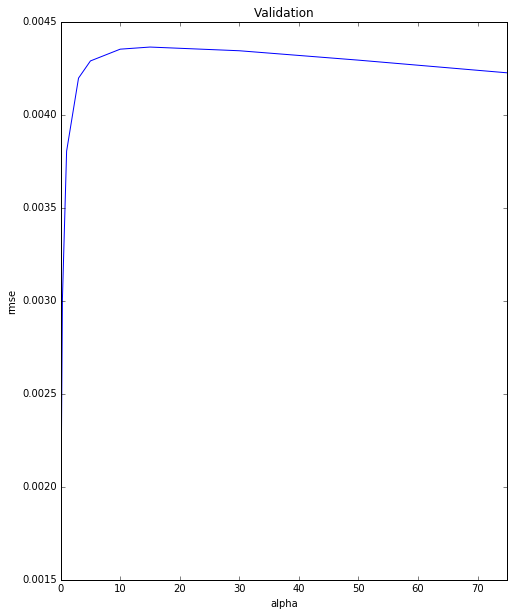

In [64]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

df= df_asset[~np.isnan(df_asset['MDI_OBD_FUEL'])]
df = df[np.isfinite(df['meter_filled'])]
time = df['recorded_at']
X = pd.DataFrame(np.log1p(df[['speed_filled','meter_filled','distance_cum','avrg_speed']]),index=df.index)

y = pd.DataFrame(np.log1p(df['MDI_OBD_FUEL'].reshape(-1,1)),index=df.index)

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [65]:
#Best alpha is 30 and it gives:
cv_ridge.min()

0.0015218452954791043

In [10]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
rmse_cv(model_lasso).mean()

/homes/wsahel/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/homes/wsahel/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/homes/wsahel/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/homes/wsahel/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y 

0.0036092154866579516

Lasso picked 1 variables and eliminated the other 3 variables


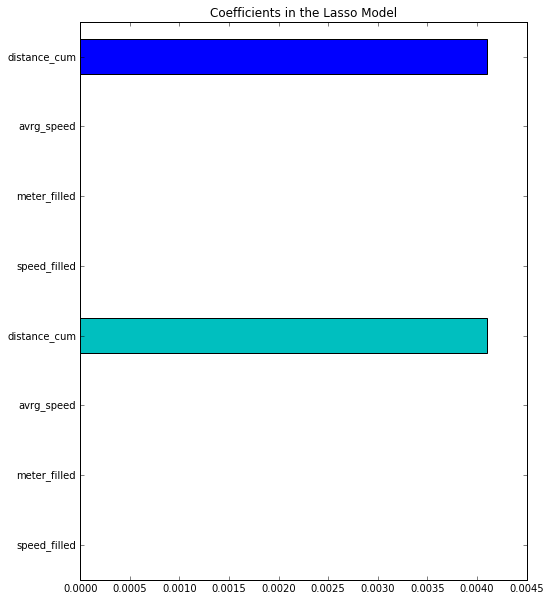

In [11]:
#Let it choose features
coef = pd.Series(model_lasso.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Importance of features:



imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])


matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

